<a href="https://colab.research.google.com/github/titobi/Brain-Tumor-Image-Classfication/blob/main/Brain_Tumor_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip uninstall -y tensorflow keras tf-keras

!pip install tensorflow==2.15 keras==2.15

# Import necessary libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn import model_selection, metrics, preprocessing
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tf_keras 2.15.1
Uninstalling tf_keras-2.15.1:
  Successfully uninstalled tf_keras-2.15.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!unzip "/content/drive/MyDrive/Brain_MRI.zip" -d "/content/drive/MyDrive/imgs/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-g

In [3]:
test_path = "/content/drive/MyDrive/imgs/Testing/"
train_path = "/content/drive/MyDrive/imgs/Training/"
image_size = (224, 224)

In [4]:
#Check the number of images in each class
def images_in_classes(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

train_count = images_in_classes(train_path)
test_count = images_in_classes(test_path)
print("Training class counts:", train_count)
print("Testing class counts:", test_count)

Training class counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing class counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


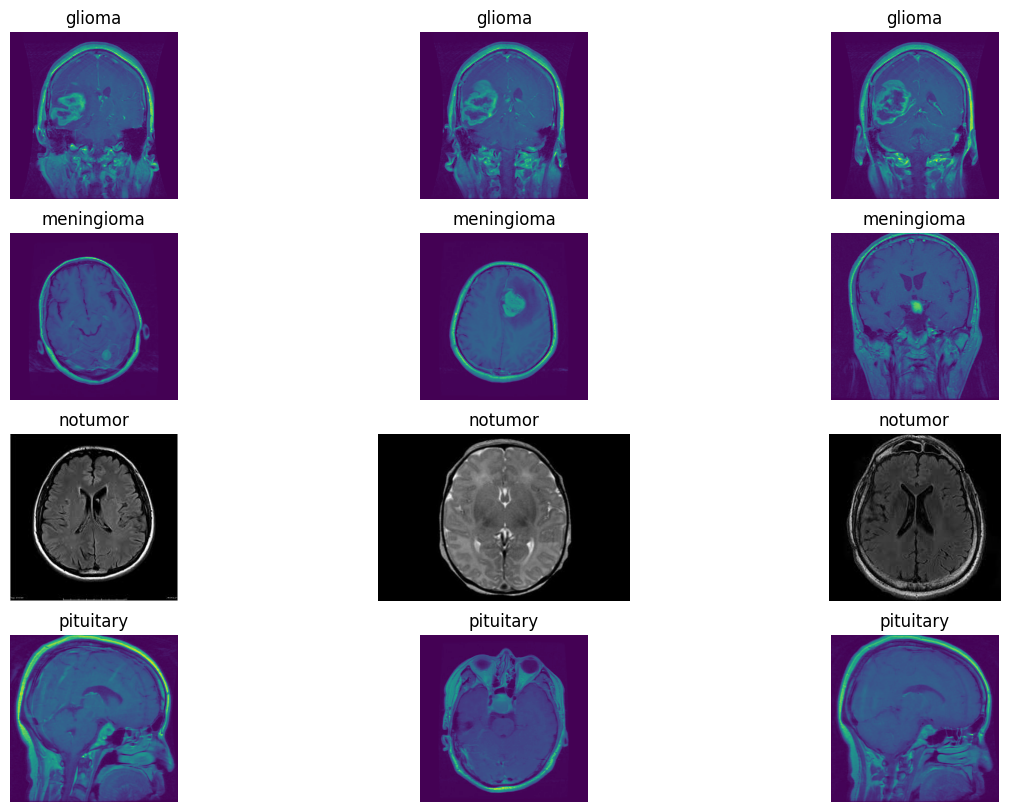

In [5]:
#Visualize some sample images from Train class
def show_sample_images(directory, classes, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        sample_images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

train_classes = os.listdir(train_path)
show_sample_images(train_path, train_classes)

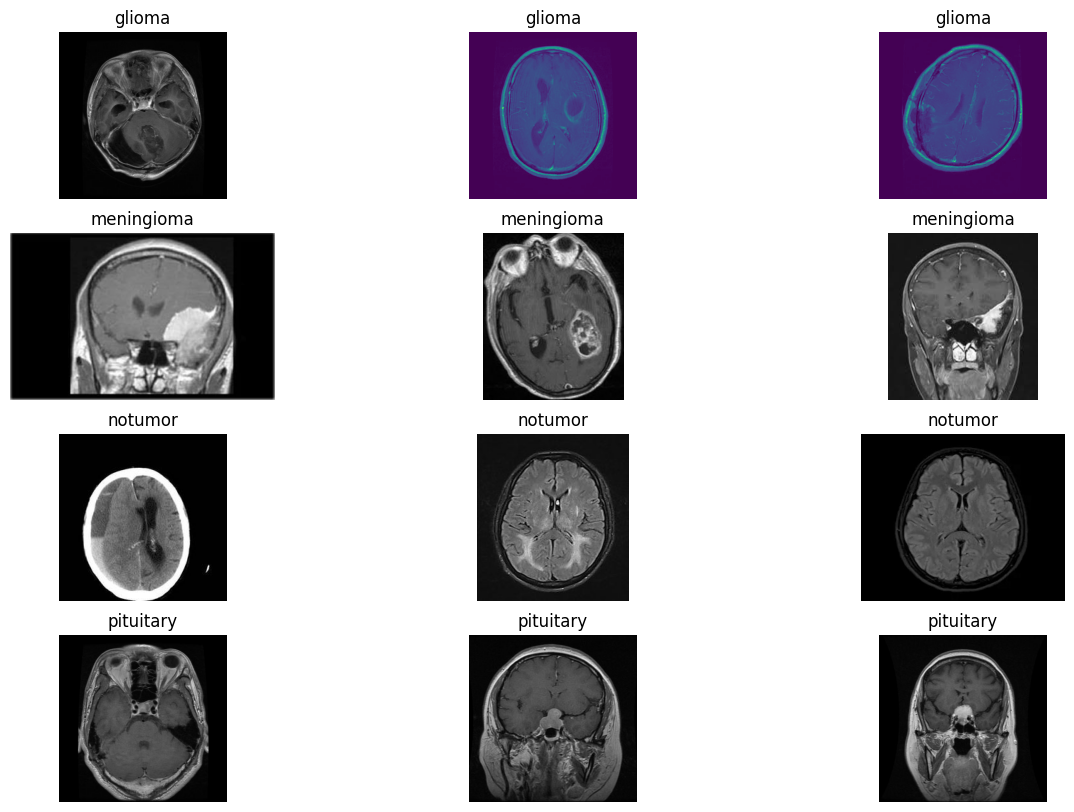

In [6]:
#Visualize some sample images from Test class
def show_sample_images(directory, classes, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        sample_images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

test_classes = os.listdir(test_path)
show_sample_images(test_path, test_classes)

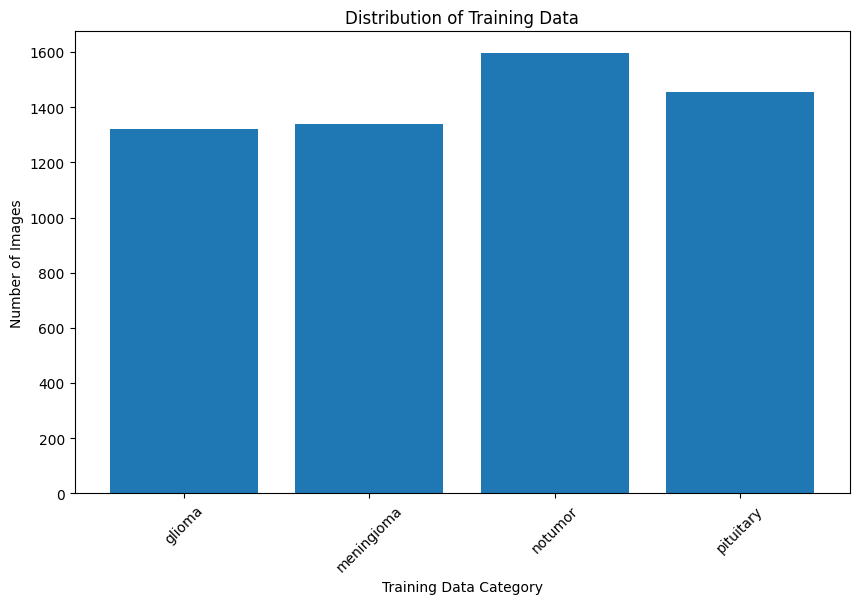

In [7]:
 # Create a bar chart showing the distribution of Train data
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Training Data Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show
plot_class_distribution(train_count, 'Distribution of Training Data')




In [8]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create generators to load and preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
# Print class indices
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

#verify images and labels are loaded correctly
images, labels = next(train_generator)
print("Batch shape:", images.shape, labels.shape)

Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Batch shape: (32, 224, 224, 3) (32, 4)


In [11]:



base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


58889256/58889256 [==============================] - 2s 0us/step


In [12]:
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Adjust the number of output classes

# Freeze the base model
base_model.trainable = False

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14847044 (56.64 MB)
Trainable params: 132356 (517.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
179/179 [==============================] - 138s 665ms/step - loss: 1.3793 - accuracy: 0.3393 - val_loss: 1.1713 - val_accuracy: 0.5195
Epoch 2/10
179/179 [==============================] - 112s 627ms/step - loss: 1.1347 - accuracy: 0.5233 - val_loss: 1.0238 - val_accuracy: 0.6278
Epoch 3/10
179/179 [==============================] - 112s 625ms/step - loss: 0.9893 - accuracy: 0.6332 - val_loss: 0.9486 - val_accuracy: 0.6407
Epoch 4/10
179/179 [==============================] - 114s 637ms/step - loss: 0.8823 - accuracy: 0.6836 - val_loss: 0.8641 - val_accuracy: 0.7033
Epoch 5/10
179/179 [==============================] - 112s 624ms/step - loss: 0.8136 - accuracy: 0.7113 - val_loss: 0.8337 - val_accuracy: 0.6880
Epoch 6/10
179/179 [==============================] - 111s 617ms/step - loss: 0.7656 - accuracy: 0.7318 - val_loss: 0.7758 - val_accuracy: 0.7155
Epoch 7/10
179/179 [==============================] - 111s 622ms/step - loss: 0.7223 - accuracy: 0.7521 - val_loss: 0.7628 -

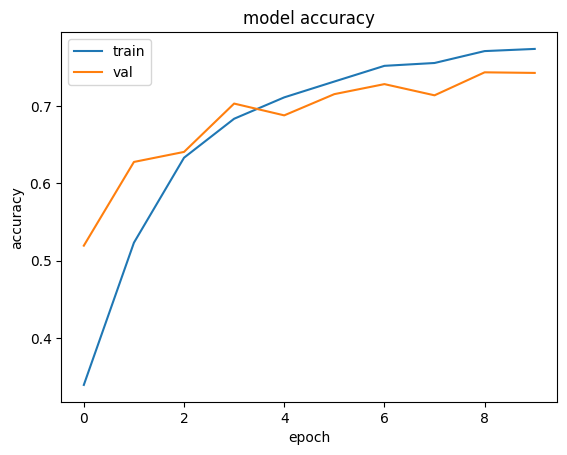

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

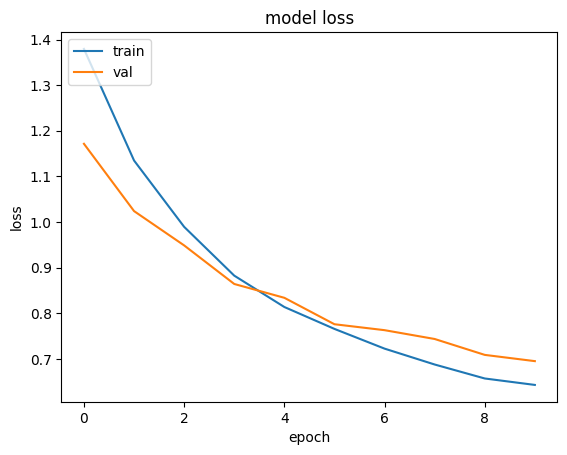

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


94765736/94765736 [==============================] - 3s 0us/step


In [19]:
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Adjust the number of output classes



In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24113284 (91.98 MB)
Trainable params: 24060164 (91.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [22]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
179/179 [==============================] - 170s 727ms/step - loss: 0.3508 - accuracy: 0.8736 - val_loss: 1.4372 - val_accuracy: 0.2929
Epoch 2/10
179/179 [==============================] - 125s 694ms/step - loss: 0.1468 - accuracy: 0.9491 - val_loss: 2.9519 - val_accuracy: 0.3089
Epoch 3/10
179/179 [==============================] - 127s 706ms/step - loss: 0.1050 - accuracy: 0.9664 - val_loss: 1.8107 - val_accuracy: 0.3875
Epoch 4/10
179/179 [==============================] - 125s 700ms/step - loss: 0.0889 - accuracy: 0.9695 - val_loss: 1.0890 - val_accuracy: 0.6117
Epoch 5/10
179/179 [==============================] - 124s 691ms/step - loss: 0.0721 - accuracy: 0.9790 - val_loss: 0.9559 - val_accuracy: 0.7002
Epoch 6/10
179/179 [==============================] - 124s 690ms/step - loss: 0.0506 - accuracy: 0.9820 - val_loss: 0.4216 - val_accuracy: 0.8871
Epoch 7/10
179/179 [==============================] - 124s 692ms/step - loss: 0.0640 - accuracy: 0.9772 - val_loss: 0.3402 -

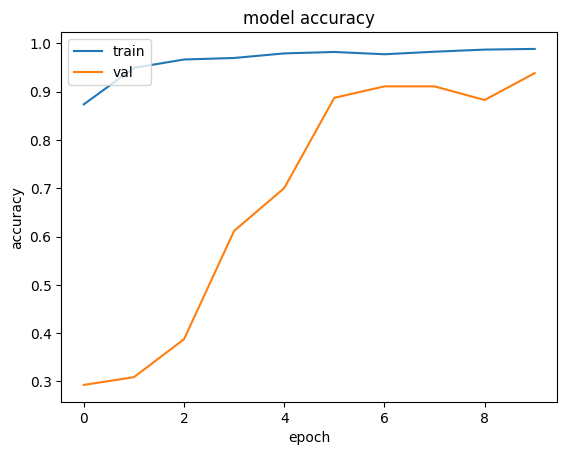

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

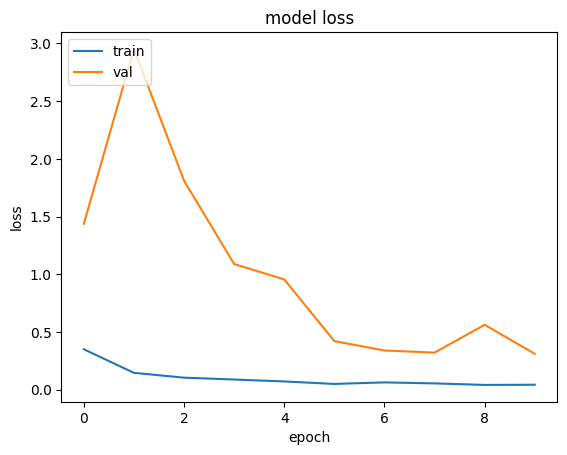

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()